<a href="https://colab.research.google.com/github/JJay1010/sw-team_project/blob/main/%EA%B9%80%EC%A7%80%EC%88%98/Chest_Ch01_ResNet152_freeze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np

x_train = np.load('/content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch01_x_train_augmented.npy')
y_train = np.load('/content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch01_y_train_augmented.npy')
x_data = np.load('/content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch01_x.npy')
y_data = np.load('/content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch01_y.npy')

In [ ]:
ratio = 1 - np.count_nonzero(y_data)/y_data.shape[0]
print(ratio)

0.4751992193852659


In [ ]:
# train/test 8:2 나누기

from sklearn.model_selection import train_test_split

_, x_test,_, y_test = train_test_split(x_data, y_data, test_size = 0.1, random_state=123)
# x_test, x_valid, y_test, y_valid = train_test_split(x_temp, y_temp, test_size = 0.5, random_state=42)
del x_data
del y_data

In [ ]:
# import imgaug.augmenters as iaa
# seq = iaa.Sequential([
#     iaa.Fliplr(0.5), # horizontally flip 50% of the images
#     iaa.Affine(rotate=(-45, 45)), # rotate images between -45 and 45 degrees
#     iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)), # add gaussian noise with a scale between 0 and 0.05 times the maximum pixel value
#     iaa.SaltAndPepper(0.05) # add 5% of salt and pepper noise
# ])
# x_train_aug = seq.augment_images(x_train)
# x_train_augmented = np.concatenate((x_train, x_train_aug))
# y_train_augmented = np.concatenate((y_train, y_train))

In [ ]:
import tensorflow as tf

saved_model = '/content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch01_ResNet152_aug_freeze.h5'
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20,restore_best_weights=True)
mc = tf.keras.callbacks.ModelCheckpoint(saved_model, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [ ]:


# Load the ResNet50 model without the top layers (include_top=False)
model = tf.keras.applications.ResNet152(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the layers of the ResNet50 model
for layer in model.layers:
    layer.trainable = False

# Add the new top layers to the ResNet50 model
x = model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# Build the final model
final_model = tf.keras.Model(inputs=model.input, outputs=predictions)

# Compile the model
custom_adam = tf.keras.optimizers.Adam(learning_rate=0.0001)

#fine tuning fit 
# metric, loss 를 binary에 맞게 바꿔주자.
final_model.compile(optimizer=custom_adam, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = final_model.fit(x_train, y_train, validation_data = (x_test, y_test), callbacks=[es, mc], epochs = 1000, batch_size = 128)


Epoch 1/1000
87/87 [==============================] - ETA: 0s - loss: 0.6294 - accuracy: 0.6421
Epoch 1: val_accuracy improved from -inf to 0.73984, saving model to /content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch01_ResNet152_aug_freeze.h5
87/87 [==============================] - 99s 1s/step - loss: 0.6294 - accuracy: 0.6421 - val_loss: 0.5174 - val_accuracy: 0.7398
Epoch 2/1000
87/87 [==============================] - ETA: 0s - loss: 0.5316 - accuracy: 0.7238
Epoch 2: val_accuracy improved from 0.73984 to 0.78374, saving model to /content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch01_ResNet152_aug_freeze.h5
87/87 [==============================] - 83s 961ms/step - loss: 0.5316 - accuracy: 0.7238 - val_loss: 0.4756 - val_accuracy: 0.7837
Epoch 3/1000
87/87 [==============================] - ETA: 0s - loss: 0.5028 - accuracy: 0.7445
Epoch 3: val_accuracy did not improve from 0.78374
87/87 [==============================] - 80s 924ms/step - loss: 0.5028 - accuracy: 0.7445 - val_loss: 0.4599 - 

In [ ]:
# np.save('/content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch01_x_train_augmented.npy',x_train_augmented)
# np.save('/content/drive/MyDrive/팀 프로젝트/흉부_xray/Ch01_y_train_augmented.npy',y_train_augmented)


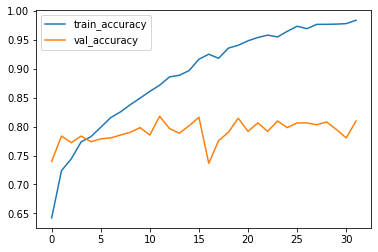

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label = 'train_accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.legend()

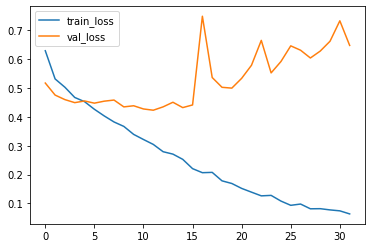

In [ ]:
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()